### Imports

In [18]:
from data_process.file_wrapper import FileWrapper
from data_process.signal_tools import signal_filter
from data_process.utils import get_by_path
from scipy.spatial.transform import Rotation
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib widget

### Load data

In [19]:
# 7/7/2023 - 20:18:13
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_07_07_2023__20_18_13/split1/split1.pkl')
data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_07_07_2023__20_18_13/split2/split2.pkl')

# 28/8/2023
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_28_08_2023__23_00_37/split1_1/split1_1.pkl')
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_28_08_2023__23_00_37/split1_2/split1_2.pkl')
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_28_08_2023__23_00_37/split2_1/split2_1.pkl')
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_28_08_2023__23_00_37/split2_2/split2_2.pkl')

# 25/8/2023 - 02:05:55
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_25_08_2023__20_17_59/rosbag2_25_08_2023__20_17_59/rosbag2_25_08_2023__20_17_59.pkl')
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_25_08_2023__02_05_55/split1/split1.pkl')

# 25/8/2023 - 20:17:59
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_25_08_2023__20_17_59/rosbag2_25_08_2023__20_17_59/rosbag2_25_08_2023__20_17_59.pkl')

# 01/10/2023 - 17:48:46
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_01_10_2023__17_48_46/split1/split1.pkl')

# 07/10/2023 - 17:42:10
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl')

# 19/11/2023 - 11:50:12
# data = FileWrapper('/home/ntkot/theses/ros/bag_db/data_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12/rosbag2_19_11_2023__11_50_12.pkl')

wien_window = 21
mv_window = 6

imu_time = get_by_path(data.data, ['/imu/static_calib', 'time'])
imu_sample_rate = 1 / np.average(imu_time[1:len(imu_time)] - imu_time[0:len(imu_time)-1])

gps_time = get_by_path(data.data, ['/gps/gprmc', 'time'])
gps_sample_rate = 1 / np.average(gps_time[1:len(gps_time)] - gps_time[0:len(gps_time)-1])

print(f'IMU sample rate: {imu_sample_rate}Hz\n'
      f'GPS sample rate: {gps_sample_rate}Hz')

a_x = get_by_path(data.data, ['/imu/static_calib', 'linear_acceleration', 'x'])
a_x_filtered = signal_filter.moving_average(signal_filter.wiener(a_x, window_length=wien_window), window_length=mv_window)
a_y = get_by_path(data.data, ['/imu/static_calib', 'linear_acceleration', 'y'])
a_y_filtered = signal_filter.moving_average(signal_filter.wiener(a_y, window_length=wien_window), window_length=mv_window)
a_z = get_by_path(data.data, ['/imu/static_calib', 'linear_acceleration', 'z'])
a_z_filtered = signal_filter.moving_average(signal_filter.wiener(a_z, window_length=wien_window), window_length=mv_window)

ground_speed = get_by_path(data.data, ['/gps/gprmc', 'ground_speed_kmh']) / 3.6
ground_speed_filtered = signal_filter.moving_average(signal_filter.wiener(ground_speed, window_length=15), window_length=2)

ground_accel = (ground_speed[1:len(ground_speed)] - ground_speed[0:len(ground_speed)-1]) * gps_sample_rate
ground_accel_filtered = (ground_speed_filtered[1:len(ground_speed_filtered)] - \
                         ground_speed_filtered[0:len(ground_speed_filtered)-1]) * gps_sample_rate
ground_accel = np.insert(ground_accel, 0, 0)
ground_accel_filtered = np.insert(ground_accel_filtered, 0, 0)

a_planar = np.sqrt(a_x ** 2 + a_y ** 2)
a_planar_filtered = np.sqrt(a_x_filtered ** 2 + a_y_filtered ** 2)

track_angle = get_by_path(data.data, ['/gps/gprmc', 'track_deg'])

Loading from pickle file...
IMU sample rate: 50.000007302850904Hz
GPS sample rate: 4.999900284989809Hz


/home/ntkot/.local/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/home/ntkot/.local/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1659: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


### Detect braking in straight line

In [20]:
gps_decel_threshold = -1.5          # m/s^2 (usually 2m/s^2)
gps_decel_samples_threshold = 5   # 5 samples -> 1 second (usually 5)
track_angle_range_threshold = 2.5   # degrees (usually 2)

counter = 0
braking = False
start_braking = []
end_braking = []
braking_track_angles = []
track_angle_list = []

for i, (accel, track_deg) in enumerate(zip(ground_accel, track_angle)):
    if accel <= gps_decel_threshold:
        track_angle_list.append(track_deg)
        counter += 1
        # print(f'Added at GPS time: {gps_time[i]}')
    else:
        if braking:
            braking = False
            if max(track_angle_list) - min(track_angle_list) < track_angle_range_threshold:
                start_braking.append(i-counter)
                end_braking.append(i-1)
                braking_track_angles.append(np.array(track_angle_list))
            else:
                print(f'Braking during {gps_time[i-counter]:.2f} - {gps_time[i-1]:.2f} '
                      f'does not satisfy track_angle_threshold ({max(track_angle_list) - min(track_angle_list):.2f}°)')
        counter = 0
        track_angle_list = []

    if counter >= gps_decel_samples_threshold and not braking:
        braking = True

if counter >= gps_decel_samples_threshold:
    start_braking.append(i-counter)
    end_braking.append(i-1)
    braking_track_angles.append(np.array(track_angle_list))

if not start_braking:
    raise ValueError('Did not find any braking zones')
else:
    print(f'Found {len(start_braking)} braking zones')
    print(gps_time[start_braking])
    print(gps_time[end_braking])
    # print(braking_track_angles)

Found 1 braking zones
[35.24453684]
[36.03551973]


### Find braking time moments on IMU data from detected GPS data
GPS data appear to have a latency of ~550ms when comparing it to IMU accelerometer data,\
so we need to find actual corresponding moments in IMU data where the vehicle decelerates

In [21]:
start_braking_imu = []
end_braking_imu   = []
imu_decel_threshold = abs(gps_decel_threshold) # m/s^2

def biggest_continuous_range(indices: list[int], biggest_discontinuity: int):
    """
        Function that accepts a list of indices and returns the range with
        the most elements that are continuous (within a range of discontinuity)
        e.g.
        args:
            indices: [1, 2, 3, 4, 5, 8, 9, 10], 
            biggest_discontinuity: 2
        returns:
            [1, 2, 3, 4, 5]
    """
    ranges = []
    curr_range = []
    for elem in indices:
        if not curr_range:
            curr_range.append(elem)
        elif elem > (curr_range[-1] + biggest_discontinuity):
            ranges.append(curr_range)
            curr_range = []
        else:
            curr_range.append(elem)
    if curr_range:
        ranges.append(curr_range)

    biggest_range = np.argmax([len(r) for r in ranges])
    return ranges[biggest_range]

for start, end in zip(start_braking, end_braking):
    gps_time_start = gps_time[start]
    gps_time_end   = gps_time[end]

    imu_slice_idx_start = min(range(len(imu_time)), key=lambda i: abs(imu_time[i] - gps_time_start)) - int(0.5 * imu_sample_rate)
    imu_slice_idx_end   = min(range(len(imu_time)), key=lambda i: abs(imu_time[i] - gps_time_end)) + int(0.5 * imu_sample_rate)

    a_planar_braking = a_planar_filtered[imu_slice_idx_start:imu_slice_idx_end]
    if np.where(a_planar_braking > imu_decel_threshold)[0].size == 0:
        print(f'INVALID DETECTED POINT ON {gps_time_start}-{gps_time_end}')
        continue
        
    # braking_slice_idx_start = np.where(a_planar_braking > imu_decel_threshold)[0][0]
    # braking_slice_idx_end   = len(a_planar_braking) - np.where(np.flip(a_planar_braking) > imu_decel_threshold)[0][0] - 1
    
    braking_ranges = biggest_continuous_range(np.where(a_planar_braking > imu_decel_threshold)[0], biggest_discontinuity = 2)
    braking_slice_idx_start = braking_ranges[0]
    braking_slice_idx_end   = braking_ranges[-1]

    start_braking_imu.append(braking_slice_idx_start + imu_slice_idx_start)
    end_braking_imu.append(braking_slice_idx_end + imu_slice_idx_start)

print(imu_time[start_braking_imu])
print(imu_time[end_braking_imu])

[34.7422709]
[36.10220942]


### Plot data with detected braking points

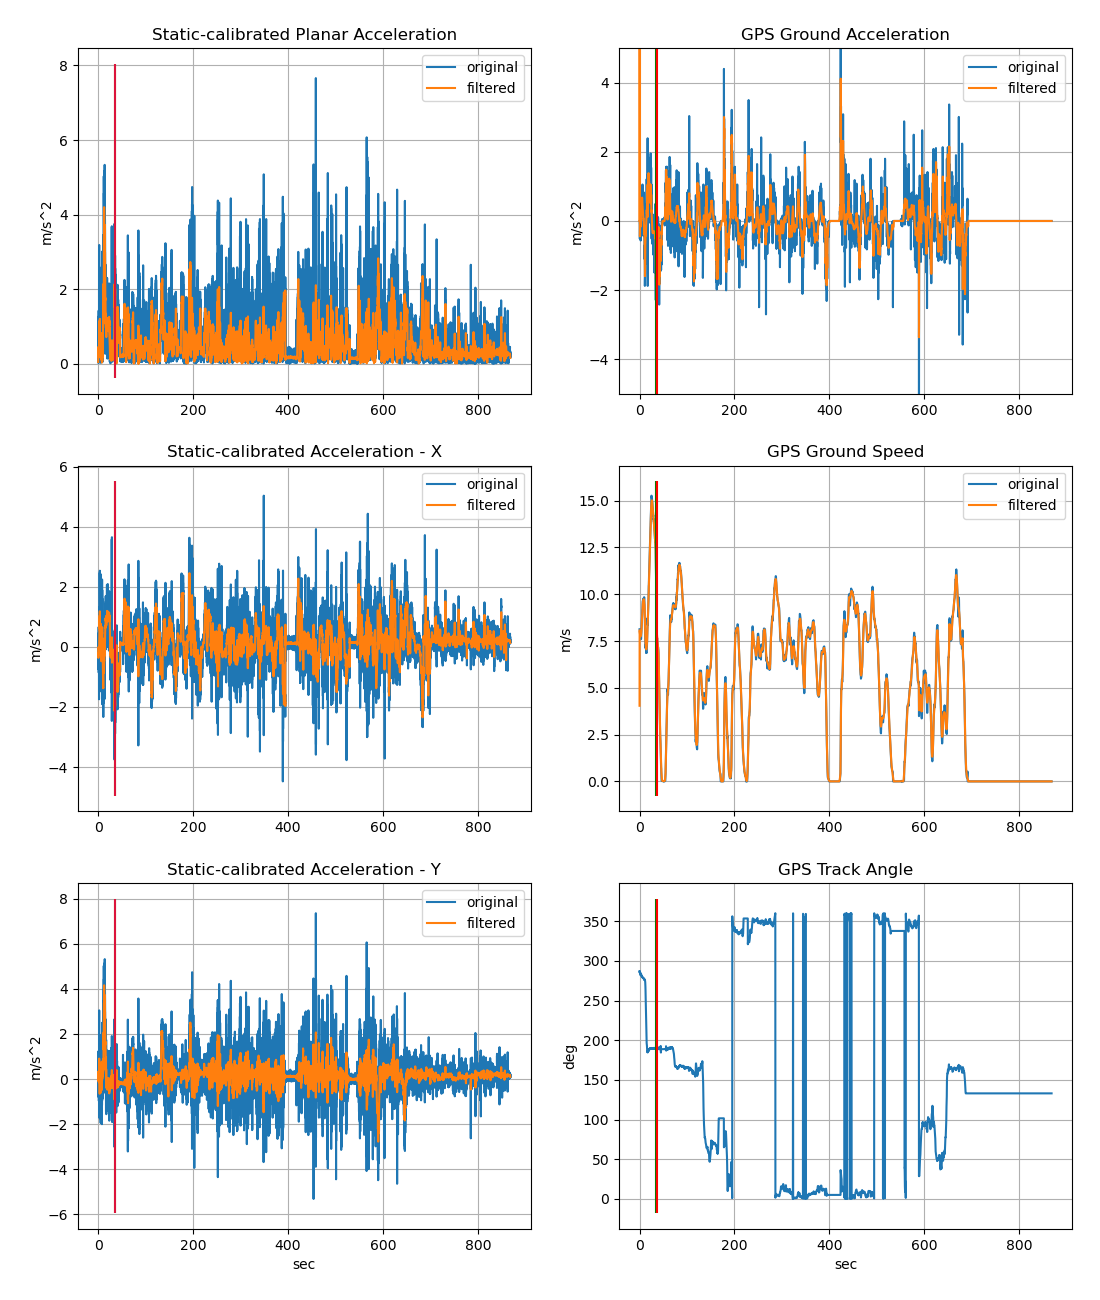

In [22]:
fig = plt.figure(1)
fig.clear()
fig, ax = plt.subplots(num=1, nrows=3, ncols=2, sharex='all')

ax[0][0].plot(imu_time, a_planar)
ax[0][0].plot(imu_time, a_planar_filtered)
ax[0][0].grid(which='both', axis='both')
ax[0][0].legend(['original','filtered'])
ax[0][0].tick_params(labelbottom=True)
ax[0][0].set_ylabel('m/s^2')
ax[0][0].set_title('Static-calibrated Planar Acceleration')
_, _, ymin, ymax = ax[0][0].axis()
ax[0][0].vlines(x=imu_time[start_braking_imu], ymin=ymin, ymax=ymax, colors='lawngreen')
ax[0][0].vlines(x=imu_time[end_braking_imu],   ymin=ymin, ymax=ymax, colors='crimson')

ax[1][0].plot(imu_time, a_x)
ax[1][0].plot(imu_time, a_x_filtered)
ax[1][0].grid(which='both', axis='both')
ax[1][0].legend(['original','filtered'])
ax[1][0].tick_params(labelbottom=True)
ax[1][0].set_ylabel('m/s^2')
ax[1][0].set_title('Static-calibrated Acceleration - X')
_, _, ymin, ymax = ax[1][0].axis()
ax[1][0].vlines(x=imu_time[start_braking_imu], ymin=ymin, ymax=ymax, colors='lawngreen')
ax[1][0].vlines(x=imu_time[end_braking_imu],   ymin=ymin, ymax=ymax, colors='crimson')

ax[2][0].plot(imu_time, a_y)
ax[2][0].plot(imu_time, a_y_filtered)
ax[2][0].grid(which='both', axis='both')
ax[2][0].legend(['original','filtered'])
ax[2][0].set_xlabel('sec')
ax[2][0].tick_params(labelbottom=True)
ax[2][0].set_ylabel('m/s^2')
ax[2][0].set_title('Static-calibrated Acceleration - Y')
_, _, ymin, ymax = ax[2][0].axis()
ax[2][0].vlines(x=imu_time[start_braking_imu], ymin=ymin, ymax=ymax, colors='lawngreen')
ax[2][0].vlines(x=imu_time[end_braking_imu],   ymin=ymin, ymax=ymax, colors='crimson')

ax[0][1].plot(gps_time, ground_accel)
ax[0][1].plot(gps_time, ground_accel_filtered)
ax[0][1].grid(which='both', axis='both')
ax[0][1].legend(['original', 'filtered'])
ax[0][1].tick_params(labelbottom=True)
ax[0][1].set_ylabel('m/s^2')
ax[0][1].set_ylim(-5,5)
ax[0][1].set_title('GPS Ground Acceleration')
_, _, ymin, ymax = ax[0][1].axis()
ax[0][1].vlines(x=gps_time[start_braking], ymin=ymin, ymax=ymax, colors='green')
ax[0][1].vlines(x=gps_time[end_braking],   ymin=ymin, ymax=ymax, colors='red')

ax[1][1].plot(gps_time, ground_speed)
ax[1][1].plot(gps_time, ground_speed_filtered)
ax[1][1].grid(which='both', axis='both')
ax[1][1].legend(['original', 'filtered'])
ax[1][1].tick_params(labelbottom=True)
ax[1][1].set_ylabel('m/s')
ax[1][1].set_title('GPS Ground Speed')
_, _, ymin, ymax = ax[1][1].axis()
ax[1][1].vlines(x=gps_time[start_braking], ymin=ymin, ymax=ymax, colors='green')
ax[1][1].vlines(x=gps_time[end_braking],   ymin=ymin, ymax=ymax, colors='red')

ax[2][1].plot(gps_time, track_angle)
ax[2][1].grid(which='both', axis='both')
ax[2][1].set_xlabel('sec')
ax[2][1].tick_params(labelbottom=True)
ax[2][1].set_ylabel('deg')
ax[2][1].set_title('GPS Track Angle')
_, _, ymin, ymax = ax[2][1].axis()
ax[2][1].vlines(x=gps_time[start_braking], ymin=ymin, ymax=ymax, colors='green')
ax[2][1].vlines(x=gps_time[end_braking],   ymin=ymin, ymax=ymax, colors='red')

fig.set_size_inches(11,13)
fig.tight_layout(pad=2)

plt.show()

### Perform dynamic calib on found braking zones (Also check if the calibration gives negative X-accel)

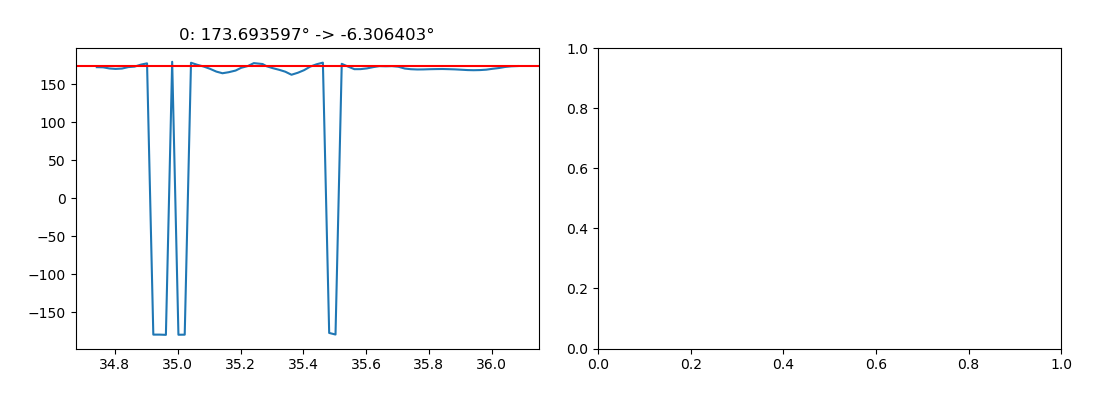

In [23]:
times = []
z_angles = []
rotations = []

z_angles_fig = plt.figure(2)
z_angles_fig.clear()
z_angles_fig, z_angles_ax = plt.subplots(num=2, nrows=math.ceil(len(start_braking_imu) / 2), ncols=2)

for i, (start, end) in enumerate(zip(start_braking_imu, end_braking_imu)):
    a_x_slice  = a_x_filtered[start:end]
    a_y_slice  = a_y_filtered[start:end]

    # if acceleration is positive, we need to make it negative
    rotation_corrected = False
    z_angle = np.average(np.percentile(np.arctan2(-a_y_slice, a_x_slice), 75.0))
    z_angles.append(z_angle)
    cosz = math.cos(z_angle)
    sinz = math.sin(z_angle)
    rot = Rotation.from_matrix([[cosz, -sinz, 0],
                                [sinz,  cosz, 0],
                                [   0,     0, 1]])
    a_x_calib_slice_avg = rot.apply(np.array([np.average(a_x_slice), np.average(a_y_slice), 0]))[0]
    if(a_x_calib_slice_avg > 0):
        # rotate matrix around z-axis by 180deg
        mat = rot.as_matrix()
        mat[0] = -mat[0]
        mat[1] = -mat[1]
        rot = Rotation.from_matrix(mat)
        # update angle
        z_angles[i] = math.atan2(math.sin(z_angles[i] + math.pi), math.cos(z_angles[i] + math.pi))
        rotation_corrected = True
    rotations.append(rot)

    # Plot results
    if math.ceil(len(start_braking_imu) / 2) > 1:
        z_angles_ax[i // 2][i % 2].plot(imu_time[start:end], np.arctan2(-a_y_slice, a_x_slice) * 180 / np.pi)
        if rotation_corrected:
            z_angles_ax[i // 2][i % 2].set_title(f'{i}: {z_angle * 180 / np.pi:2f}° -> {z_angles[i] * 180 / np.pi:2f}°')
        else:
            z_angles_ax[i // 2][i % 2].set_title(f'{i}: {z_angle * 180 / np.pi:2f}°')
        z_angles_ax[i // 2][i % 2].axhline(y=z_angle * 180 / np.pi, color='r')
    else:
        z_angles_ax[i % 2].plot(imu_time[start:end], np.arctan2(-a_y_slice, a_x_slice) * 180 / np.pi)
        if rotation_corrected:
            z_angles_ax[i % 2].set_title(f'{i}: {z_angle * 180 / np.pi:2f}° -> {z_angles[i] * 180 / np.pi:2f}°')
        else:
            z_angles_ax[i % 2].set_title(f'{i}: {z_angle * 180 / np.pi:2f}°')
        z_angles_ax[i % 2].axhline(y=z_angle * 180 / np.pi, color='r')

z_angles_fig.set_size_inches(11,4 * math.ceil(len(start_braking_imu) / 2))
z_angles_fig.tight_layout(pad=2.0)

plt.show()

### Add custom z-angle (optional)

In [24]:
new_z_angle = -1 * math.pi / 180.0
cosz = math.cos(new_z_angle)
sinz = math.sin(new_z_angle)
z_angles.append(new_z_angle)
rotations.append(Rotation.from_matrix([[cosz, -sinz, 0],
                                       [sinz,  cosz, 0],
                                       [   0,     0, 1]]))

new_z_angle = -3 * math.pi / 180.0
cosz = math.cos(new_z_angle)
sinz = math.sin(new_z_angle)
z_angles.append(new_z_angle)
rotations.append(Rotation.from_matrix([[cosz, -sinz, 0],
                                       [sinz,  cosz, 0],
                                       [   0,     0, 1]]))

### Use above angles to calibrate data

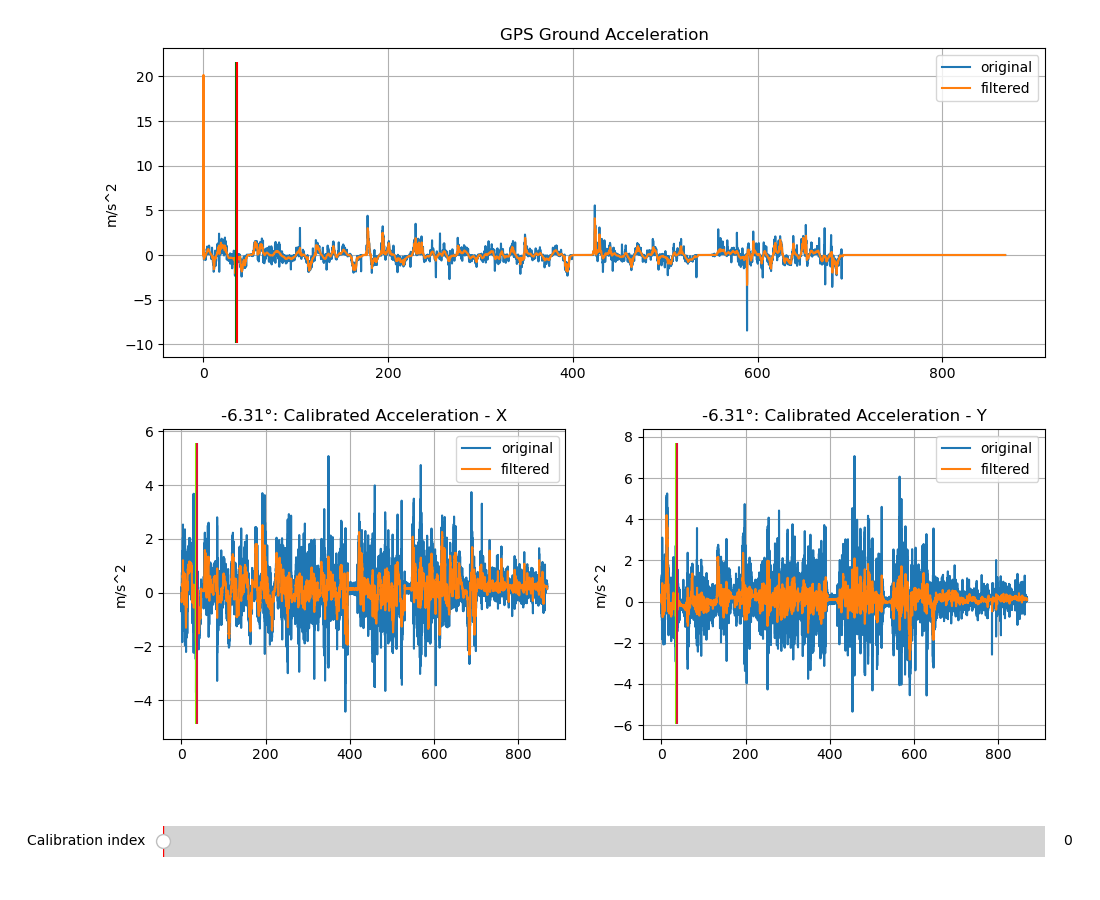

In [25]:
calib_fig = plt.figure(3)
calib_fig.clear()
gs_kw = dict(height_ratios=[1, 1, 0.2])
calib_fig, calib_ax = plt.subplot_mosaic(num=3, mosaic=[['gps_acc', 'gps_acc'],
                                                        ['acc_x',   'acc_y'],
                                                        ['slider',  'slider']], gridspec_kw=gs_kw)

calib_used_slider = Slider(ax=calib_ax['slider'], label='Calibration index', 
                           valmin=0, 
                           valmax=len(rotations)-1, 
                           valinit=0, 
                           valstep=1)

calib_ax['gps_acc'].plot(gps_time, ground_accel)
calib_ax['gps_acc'].plot(gps_time, ground_accel_filtered)
calib_ax['gps_acc'].tick_params(labelbottom=True)
calib_ax['gps_acc'].grid(which='both', axis='both')
calib_ax['gps_acc'].set_ylabel('m/s^2')
calib_ax['gps_acc'].legend(['original','filtered'])
calib_ax['gps_acc'].set_title('GPS Ground Acceleration')
_, _, ymin, ymax = calib_ax['gps_acc'].axis()
calib_ax['gps_acc'].vlines(x=gps_time[start_braking], ymin=ymin, ymax=ymax, colors='green')
calib_ax['gps_acc'].vlines(x=gps_time[end_braking],   ymin=ymin, ymax=ymax, colors='red')

def change_calibration(idx):
    xmin, xmax, _, _ = calib_ax['gps_acc'].axis()
    
    idx = int(idx)
    rot = rotations[idx]
    a_x_calib,          a_y_calib,          _ = rot.apply(np.array([a_x,          a_y,          a_z]).T).T
    a_x_filtered_calib, a_y_filtered_calib, _ = rot.apply(np.array([a_x_filtered, a_y_filtered, a_z_filtered]).T).T
    
    calib_ax['acc_x'].clear()
    calib_ax['acc_y'].clear()
    
    calib_ax['acc_x'].plot(imu_time, a_x_calib)
    calib_ax['acc_x'].plot(imu_time, a_x_filtered_calib)
    calib_ax['acc_x'].grid(which='both', axis='both')
    calib_ax['acc_x'].legend(['original','filtered'])
    calib_ax['acc_x'].set_ylabel('m/s^2')
    calib_ax['acc_x'].set_title(f'{z_angles[idx] * 180 / np.pi:.2f}°: Calibrated Acceleration - X')
    _, _, ymin, ymax = calib_ax['acc_x'].axis()
    calib_ax['acc_x'].vlines(x=imu_time[start_braking_imu], ymin=ymin, ymax=ymax, colors='lawngreen')
    calib_ax['acc_x'].vlines(x=imu_time[end_braking_imu],   ymin=ymin, ymax=ymax, colors='crimson')
    
    calib_ax['acc_y'].plot(imu_time, a_y_calib)
    calib_ax['acc_y'].plot(imu_time, a_y_filtered_calib)
    calib_ax['acc_y'].grid(which='both', axis='both')
    calib_ax['acc_y'].legend(['original','filtered'])
    calib_ax['acc_y'].set_ylabel('m/s^2')
    calib_ax['acc_y'].set_title(f'{z_angles[idx] * 180 / np.pi:.2f}°: Calibrated Acceleration - Y')
    _, _, ymin, ymax = calib_ax['acc_y'].axis()
    calib_ax['acc_y'].vlines(x=imu_time[start_braking_imu], ymin=ymin, ymax=ymax, colors='lawngreen')
    calib_ax['acc_y'].vlines(x=imu_time[end_braking_imu],   ymin=ymin, ymax=ymax, colors='crimson')

    calib_ax['gps_acc'].set_xlim(xmin, xmax)

change_calibration(0)
calib_ax['gps_acc'].set_xlim(0 - 0.025*max(gps_time), 1.025*max(gps_time))
calib_used_slider.on_changed(change_calibration)

calib_ax['gps_acc'].sharex(calib_ax['acc_x'])
calib_ax['acc_x'].sharex(calib_ax['acc_y'])

calib_fig.set_size_inches(11, 9)
calib_fig.tight_layout(pad=2)

plt.show()